In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

In [ ]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

<Figure size 432x288 with 0 Axes>

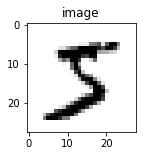

图像数据形状和对应数据为: (28, 28)
图像标签形状和对应数据为: (1,) [5]

打印第一个batch的第一个图像，对应标签数字为[5]


In [ ]:
#加载飞桨和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

train_dataset = paddle.vision.datasets.MNIST(mode='train')

train_data0 = np.array(train_dataset[0][0])
train_label_0 = np.array(train_dataset[0][1])

# 显示第一batch的第一个图像
import matplotlib.pyplot as plt
plt.figure("Image") # 图像窗口名称
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

print("图像数据形状和对应数据为:", train_data0.shape)
print("图像标签形状和对应数据为:", train_label_0.shape, train_label_0)
print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(train_label_0))



In [10]:
import paddle
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

#数据处理部分之前的代码，保持不变
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import paddle.nn.functional as F
import gzip
import json
import paddle.fluid as fluid

# 定义数据集读取器
def load_data(mode='train'):

    # 加载数据
    datafile = 'data/data17155/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')

    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    # IMG_ROWS = 28
    # IMG_COLS = 28

    if mode == 'train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode == 'valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode == 'eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")

    #校验数据
    imgs_length = len(imgs)
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    # 定义数据集每个数据的序号， 根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            # img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            # label = np.reshape(labels[i], [1]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

In [19]:
import paddle
from paddle.vision.transforms import Compose, Normalize
import paddle.nn.functional as F
import numpy as np
from paddle.metric import Accuracy
import random
from paddle import fluid
from visualdl import LogWriter

log_writer=LogWriter("./data/log/train") #log记录器


transform = Compose([Normalize(mean=[127.5],
                               std=[127.5],
                               data_format='CHW')])
#归一化

#读取训练集 测试集数据
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform)



# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

#数据处理部分之前的代码，保持不变
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import paddle.nn.functional as F
import gzip
import json
import paddle.fluid as fluid
from paddle.fluid.dygraph import Conv2D, Pool2D, Linear, Dropout, BatchNorm


class InceptionA(paddle.nn.Layer):  #作为网络一层
    def __init__(self,in_channels):
        super(InceptionA,self).__init__()
        self.branch3x3_1=paddle.nn.Conv2D(in_channels,16,kernel_size=1) #第一个分支
        self.branch3x3_2=paddle.nn.Conv2D( 16,24,kernel_size=3,padding=1)
        self.branch3x3_3=paddle.nn.Conv2D(24,24,kernel_size=3,padding=1)

        self.branch5x5_1=paddle.nn.Conv2D(in_channels, 16,kernel_size=1) #第二个分支
        self.branch5x5_2=paddle.nn.Conv2D( 16,24,kernel_size=5,padding=2)

        self.branch1x1=paddle.nn.Conv2D(in_channels, 16,kernel_size=1) #第三个分支

        self.branch_pool=paddle.nn.Conv2D(in_channels,24,kernel_size= 1) #第四个分支

    def forward(self,x):
        #分支1处理过程
        branch3x3= self.branch3x3_1(x)
        branch3x3= self.branch3x3_2(branch3x3)
        branch3x3= self.branch3x3_3(branch3x3)
        #分支2处理过程
        branch5x5=self.branch5x5_1(x)
        branch5x5=self.branch5x5_2(branch5x5)
        #分支3处理过程
        branch1x1=self.branch1x1(x)
        #分支4处理过程
        branch_pool=F.avg_pool2d(x,kernel_size=3,stride=1,padding= 1)
        branch_pool=self.branch_pool(branch_pool)
        outputs=[branch1x1,branch5x5,branch3x3,branch_pool]     #将4个分支的输出拼接起来
        return fluid.layers.concat(outputs,axis=1) #横着拼接， 共有24+24+16+24=88个通道



class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST,self).__init__()
        #定义两个卷积层
        self.conv1=paddle.nn.Conv2D(1,10,kernel_size=5)
        self.conv2=paddle.nn.Conv2D(88,20,kernel_size=5)
        #Inception模块的输出均为88通道
        self.incep1=InceptionA(in_channels=10 )
        self.incep2=InceptionA(in_channels=20)
        self.mp=paddle.nn.MaxPool2D(2)
        self.fc=paddle.nn.Linear(1408,10) #5*5* 88 =2200，图像高*宽*通道数
    def forward(self,x):
        x=F.relu(self.mp(self.conv1(x)))# 卷积池化，relu  输出x为图像尺寸14*14*10
        x =self.incep1(x)               #图像尺寸14*14*88

        x =F.relu(self.mp(self.conv2(x)))# 卷积池化，relu  输出x为图像尺寸5*5*20
        x = self.incep2(x)              #图像尺寸5*5*88

        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        x = self.fc(x)
        return x



model = paddle.Model(MNIST())   # 封装模型
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters()) # adam优化器

# 配置模型
model.prepare(
    optim,
    paddle.nn.CrossEntropyLoss(),
    Accuracy()
    )
# 训练模型
model.fit(train_dataset,epochs=2,batch_size=64,verbose=1)
#评估
model.evaluate(test_dataset, batch_size=64, verbose=1)

#训练
def train(model,Batch_size=64):
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
    model.train()
    iterator = 0
    epochs = 10
    total_steps = (int(50000//Batch_size)+1)*epochs
    lr = paddle.optimizer.lr.PolynomialDecay(learning_rate=0.01,decay_steps=total_steps,end_lr=0.001)
    optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    # 用Adam作为优化函数
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = F.cross_entropy(predicts, y_data)
            # 计算损失
            acc = paddle.metric.accuracy(predicts, y_data)
            loss.backward()
            if batch_id % 200 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
                log_writer.add_scalar(tag='acc',step=iterator,value=acc.numpy())
                log_writer.add_scalar(tag='loss',step=iterator,value=loss.numpy())
                iterator+=200
            optim.step()
            optim.clear_grad()
        paddle.save(model.state_dict(),'./data/checkpoint/mnist_epoch{}'.format(epoch)+'.pdparams')
        paddle.save(optim.state_dict(),'./data/checkpoint/mnist_epoch{}'.format(epoch)+'.pdopt')


#测试
def test(model):
    # 加载测试数据集
    test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
    model.eval()
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = F.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data)
        if batch_id % 20 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, loss.numpy(), acc.numpy()))

#随机抽取100张图片进行测试
def random_test(model,num=100):
    select_id = random.sample(range(1, 10000), 100) #生成一百张测试图片的下标
    test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
    for batch_id, data in enumerate(test_loader()):
        x_data = data[0]
        label = data[1]
    predicts = model(x_data)
    #返回正确率
    acc = paddle.metric.accuracy(predicts, label)
    print("正确率为：{}".format(acc.numpy()))


if __name__ == '__main__':
    model = MNIST()
    train(model)
    test(model)
    random_test(model)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/2
step 938/938 [==============================] - loss: 0.1892 - acc: 0.9317 - 13ms/step         
Epoch 2/2
step 938/938 [==============================] - loss: 0.0064 - acc: 0.9725 - 12ms/step         
Eval begin...
step  30/157 [====>.........................] - loss: 0.1455 - acc: 0.9708 - ETA: 0s - 7ms/st